# SMS Spam Detection

# Installing the dataset

In [0]:
%%shell

if ! [ -d "./dataset" ]; then
  mkdir dataset
  echo "> Created the dataset directory"
fi

if ! [ -f "./dataset/SMSSpamCollection" ]; then
  rm -f ./dataset/smsspamcollection.zip
  wget -P ./dataset https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
  
  echo "> Downloaded the dataset"
  
  sudo apt-get install -y unzip
  unzip ./dataset/smsspamcollection.zip -d ./dataset
fi


> Created the dataset directory
--2019-09-06 11:02:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘./dataset/smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K  --.-KB/s    in 0.09s   

2019-09-06 11:02:37 (2.16 MB/s) - ‘./dataset/smsspamcollection.zip’ saved [203415/203415]

> Downloaded the dataset
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Archive:  ./dataset/smsspamcollection.zip
  inflating: ./dataset/SMSSpamCollection  
  inflating: ./dataset/readme        


In [0]:
import pandas as pd

In [0]:
dataset = pd.read_csv('./dataset/SMSSpamCollection', sep="\t")
dataset.columns = ['spam', 'text']
dataset.spam = dataset.spam.map({'ham': 0, 'spam': 1})

print(f"Size of the dataset: {dataset.shape[0]}")

dataset.head(10)

Size of the dataset: 5571


,spam,text
0,0,Ok lar... Joking wif u oni...
1,1,Free entry in 2 a wkly comp to win FA Cup fina...
2,0,U dun say so early hor... U c already then say...
3,0,"Nah I don't think he goes to usf, he lives aro..."
4,1,FreeMsg Hey there darling it's been 3 week's n...
5,0,Even my brother is not like to speak with me. ...
6,0,As per your request 'Melle Melle (Oru Minnamin...
7,1,WINNER!! As a valued network customer you have...
8,1,Had your mobile 11 months or more? U R entitle...
9,0,I'm gonna be home soon and i don't want to tal...


# Preprocessing

### Installing and import the dependecies

In [0]:
import re
import nltk
from nltk.tokenize import WhitespaceTokenizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### 1. Cleaning:
    Clear and get only the main part from the dataset
    Ex: remove the tags of the html.
    Ex: filter the texts in PDF and etc.

In [0]:
def clean(text):
    # Remove the HTML tags
    text = re.sub("<!--?.*?-->","",text)
    text = re.sub("<.*?>","",text)
    
    return text

### 2. Normalization:
    Remove the pontuation, tags, put everything in same case and etc.

In [0]:
def normalize(text):
    # Convert to lower case
    text = text.lower()
    
    # remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ",text)
    
    text = text.replace('  ', ' ')
    
    return text

### 3. Tokenization:
    Split the text in words spliting by the whitespaces.

In [0]:
def tokenizer(text):    
    tokenizer = WhitespaceTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens

### 4. Stop Words:
    They are words witch don't get no one meaning, they are just used to complement the context,
    and to connect the terms.
    Ex: 'i', 'you', 'in', 'out', 'are', 'the'

In [0]:
from nltk.corpus import stopwords

# Remove the stop words, they are words witch don't give no one especific meaning
def remove_stopwords(tokens):
    return [w for w in tokens if w not in stopwords.words("english")]

### 5. Stemming:
    Takes of the variation of the words and remove the finally to combine than.
    Ex: 'change', 'changing', 'changes' => 'chang'


### 6. Lemmatization:
    Takes the variation of the same word and convert to the same one (Noun).
    Ex: 'is', 'were', 'was' => 'be'
    Ex: 'ones' => 'one'

    Part of Speech(PoS) (Verb):
    Ex: 'bored' => 'bore'
    Ex: 'stating' => 'start'

In [0]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Remove the pural
# Remove the verb conjugation
def stem(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in words]

# Remove the personality
def lem(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in words]

### 7. Tag filtering
    Filter the words according with the part of speech like a noun, verbs, adverbs and etc.

In [0]:
import nltk

# RB | RB | JJ | NN | NNP | JJ | JJS | IN | VB | VBZ | VBD | VBG

# IN = preposition/subordinating conjunction

# RB = adverb very, silently
# RBR = adverb, comparative better
# RBS = adverb, superlative best
# RP = particle give up

# IN = preposition/subordinating conjunction
# JJ = adjective ‘big’
# JJR = adjective, comparative ‘bigger’
# JJS = adjective, superlative ‘biggest’

# VB verb, base form take
# VBD verb, past tense took
# VBG verb, gerund/present participle taking
# VBN verb, past participle taken
# VBP verb, sing. present, non-3d take
# VBZ verb, 3rd person sing. present takes

# Filter using regular array
def filter_tokens(tokens):
    tags = [x[1] for x in nltk.pos_tag(list(tokens))]
    filters = ("RB", "RBR", "RBS", "RP", "JJ", "JJR", "JJS", "JJ", "VB")
    
    return [tokens[i] for i in range(len(tokens)) if tags[i] in filters]

### 8. Remove the numbers
    In this case, we have an occurs of numbers, but the numbers can be variate and that variation don't give to us some new meaning. To resolve that problem, it's possible to substitute the word with has numbers to 'number'

In [0]:
def transform_numbers(tokens):
    return ["number" if bool(re.search(r'\d', w)) else w for w in tokens]

# Bag of Words

    Now let's create our word dictinary, called too Bag of Words(BoW)

In [0]:
# Concatenate all texts
all_words = " ".join(list(dataset.text))

# Normalise and clean then
text = normalize(clean(all_words))
print("> Normalized!")

# Split in tokens
tokens = tokenizer(text)
print("> Tokenized!")

# Remove the stop of words
tokens = remove_stopwords(tokens)
print("> Removed the stop words!")

# Group by the words using Stem and Lemmantize techiniques
# tokens = stem(tokens)
tokens = lem(tokens)
print("> Merged the term to the root form!")

# Filter the words accourding with the Part of Speech
tokens = filter_tokens(tokens)
print("> Filtred by tags witch get more meaning!")

# Convert the numbers to simple string 'number'
tokens = transform_numbers(tokens)
print("> Transformed the numbers")

# Show the first 100 words 
print("\nColection [:100]:\n")

for i in range(10):
  print(tokens[(10 * i):(10 * i + 10)])

> Normalized!
> Tokenized!
> Removed the stop words!
> Merged the term to the root form!
> Filtred by tags witch get more meaning!
> Transformed the numbers

Colection [:100]:

['ok', 'lar', 'u', 'oni', 'free', 'fa', 'final', 'text', 'fa', 'receive']
['txt', 'u', 'early', 'u', 'already', 'nah', 'go', 'usf', 'back', 'still']
['ok', 'even', 'brother', 'speak', 'nurungu', 'callertune', 'prize', 'reward', 'valid', 'mobile']
['u', 'update', 'latest', 'free', 'mobile', 'update', 'free', 'soon', 'want', 'anymore']
['tonight', 'enough', 'win', 'csh', 'p', 'tsandcs', 'apply', 'reply', 'hl', 'urgent']
['free', 'prize', 'dbuk', 'net', 'right', 'take', 'fulfil', 'wonderful', 'next', 'txt']
['eh', 'u', 'yes', 'v', 'v', 'fine', 'u', 'feel', 'miss', 'ur']
['national', 'try', 'wale', 'seriously', 'spell', 'try', 'ha', 'ü', 'first', 'lar']
['str', 'u', 'finish', 'ur', 'already', 'ffffffffff', 'alright', 'sooner', 'eat', 'really']
['hungry', 'sick', 'pizza', 'always', 'love', 'back', 'amp', 'know', 'ahh

### Get the frequency of the words

In [0]:
import nltk

# Get the frequency of the words
frequency = nltk.FreqDist(tokens)

# Create the bag of words dataframe
bag_of_words = pd.DataFrame({"words": list(frequency.keys()), "frequency": list(frequency.values())})

# Order by the Frequency
bag_of_words.sort_values(by="frequency", ascending=False, inplace=True)
bag_of_words.reset_index(drop=True, inplace=True)

# Save the bag of words
bag_of_words.to_csv('./dataset/bag-of-words.csv', index=True)

print(f"Back of words size: {bag_of_words.shape[0]}")

print(bag_of_words.shape[0])
bag_of_words.head(5)

Back of words size: 2856
2856


,words,frequency
0,u,1092
1,ur,350
2,free,288
3,good,247
4,get,230


### Plot the frequency in Word Cloud

In [0]:
def to_single_str(words, frequency):
    words = list(words)
    frequency = list(frequency)
    
    return " ".join([(str(words[i]) + " ") * int(frequency[i]) for i in range(len(frequency))])

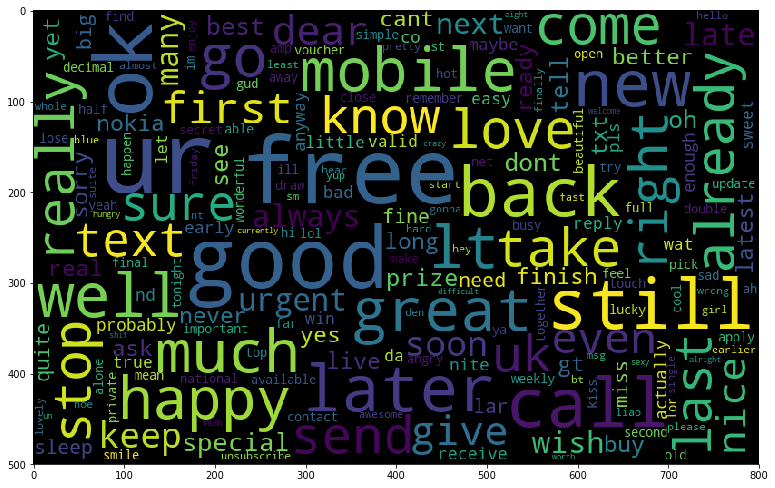

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a wordcloud image
word_cloud = WordCloud(width=800, height=500, background_color='#000', max_font_size=110, collocations=False).generate(to_single_str(bag_of_words["words"], bag_of_words["frequency"]))

# Configure the plot
plt.figure(figsize=(13, 13))
plt.imshow(word_cloud)
plt.show()

### Remove unnecessary variable

In [0]:
del word_cloud
del all_words
del text
del tokens
del frequency
del bag_of_words

# TF-IDF

### Config

In [0]:
# Load the dictinary
bag_of_words = pd.read_csv('./dataset/bag-of-words.csv')
bag_of_words_array = bag_of_words.words.values

# Load the dataset
dataset = pd.read_csv('./dataset/SMSSpamCollection', sep="\t")
dataset.columns = ['spam', 'text']
dataset.spam = dataset.spam.map({'ham': 0, 'spam': 1})
inputs = dataset.text.values

### Implemetation

In [0]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF function
def tf_idf(txt, vocabulary=None):
    txt = list(txt)

    # Vectorize using the vocabulary and without the normalization
    tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word', vocabulary=vocabulary)
    txt_transformed = tf.fit(txt).transform(txt)

    
    return txt_transformed.toarray(), tf.get_feature_names()

In [0]:
tfidf, feature_names = tf_idf(inputs, bag_of_words_array)

# Show the TF-IDF
view = pd.DataFrame(tfidf, columns=feature_names)
view.head(10)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1278: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


,u,ur,free,good,get,ok,still,back,call,new,later,n,well,much,mobile,great,lt,happy,go,come,already,love,really,right,take,stop,last,send,also,know,uk,sure,text,first,even,give,dear,nice,keep,soon,...,arul,cum,gep,bowa,feathery,payback,howz,asshole,j,mary,adewale,hittng,minapn,ja,aom,gbp,cutest,ponnungale,intha,spotty,nickey,midnight,aiya,simulate,autocorrect,mathe,po,soooo,nb,uwant,mca,latelyxxx,eerie,drugdealer,eldest,brown,bck,yelow,shadow,heap
0,0.0,0.0,0.000000,0.0,0.0,3.99054,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,4.191608,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,4.466275,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5.136693,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,3.99054,4.581905,4.634897,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.35233,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,5.514456,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,3.315412,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,8.383216,0.0,0.0,0.00000,0.000000,0.000000,3.315412,0.0,0.0,0.0,0.0,0.0,9.546599,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.

### Remove unnecessary variable

In [0]:
del view

# Naive Bayes

### Config

In [0]:
from sklearn.model_selection import train_test_split

# Create the resources
X = tfidf
y = dataset.spam.values

# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify = y)

### Model

In [0]:
from sklearn.naive_bayes import MultinomialNB

# Create a Multinomial bayes model from sklearn
model = MultinomialNB()

# Fit the model
model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Score the model

In [0]:
from IPython.core.display import display, HTML

# Predict using text X
y_pred = model.predict(X_test)
# 
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
result = "Accuracy: %.2f" % (accuracy*100) + "%"

# Show the result in HTML
display(HTML(f'<h2>{result}</h2>'))